# Challenge 1

### Objective

Craft a captivating story told through a sequence of 4-5 images, created using Stable Diffusion text-to-image, image to image models. Your task is to narrate a tale, where each image seamlessly leads to the next, creating a visual narrative. For eg, it could be a comic with 4 images.

### Hints:

- Story Crafting: Start with a clear storyline. Think of each image as a chapter in your story
- Prompt Engineering: For each image, craft detailed prompts. The more specific you are, the better. However, avoid overly complicated prompts as they may lead to confusion. Include descriptors for subject, environment, mood, etc. Checkout different prompting techniques online if you are new to prompt engineering, here is a pdf on prompting for stable diffusion I found online
- Sequencing: Ensure each image has a logical or thematic connection to the next, maintaining a consistent narrative flow.
- Narrative Coherence: The challenge is to create a coherent visual story, where each image is both a standalone piece and a part of the larger narrative.

Let's get started by setting up few things and importing the required python packages!

In [2]:
# Required packages, install if not installed (assume PyTorch* and Intel® Extension for PyTorch* is already present)
# #import sys
!echo "Installation in progress..."
# !conda install -y --quiet  --prefix {sys.prefix} -c conda-forge \
#     accelerate==0.23.0 \
#     validators==0.22.0 \
#     diffusers==0.18.2 \
#     transformers==4.32.1 \
#     pillow \
#     ipywidgets \
#     ipython > /dev/null && echo "Installation successful" || echo "Installation failed"
import sys
!{sys.executable} -m pip install invisible-watermark --user > /dev/null 2>&1
!{sys.executable} -m pip install transformers huggingface-hub --user > /dev/null 2>&1
!echo "Installation complete..."

Installation in progress...
Installation complete...


In [3]:
from io import BytesIO
import os
import random
import time
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

# Suppress warnings for a cleaner output.
warnings.filterwarnings("ignore")

import requests
import torch
import torch.nn as nn
import intel_extension_for_pytorch as ipex  # Used for optimizing PyTorch models
from PIL import Image

from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

---

**A Glimpse Behind the Scenes**

For those intrigued by the underpinnings of this adventure, let's delve into the technicalities of the code. No worries if you're not aiming for a deep dive; understanding this isn't a prerequisite to run the notebook. But for the tech-curious, let's dissect:

- **Class**: At the heart of our operations is the `Text2ImgModel` class. This class defines the process of transforming textual prompts into visual masterpieces.

- **Pipeline Loading**: The `_load_pipeline` function is where we bring the pre-trained model onboard. This sets the stage for all our text-to-image transformations.

- **Optimization**: Performance is paramount. With the `_optimize_pipeline` and `optimize_pipeline` methods, we leverage Intel-specific optimizations using the Intel Extension For PyTorch (IPEX) to ensure our model runs fast!.

- **The Grand Finale - Image Generation**: The `generate_images` method is where dreams meet reality. It interprets the textual prompts, consults with the model, and then crafts images that encapsulate the essence of the prompts. You can choose the model, provide a prompt and specify the number of images.

Intrigued? Dive into the code below and see how we've tailored the image generation pipeline, ensuring it's optimized for Intel GPUs.

---


In [15]:
class Text2ImgModel:
    """
    Text2ImgModel is a class for generating images based on text prompts using a pretrained model.

    Attributes:
    - device: The device to run the model on. Default to "xpu" - Intel dGPUs.
    - pipeline: The loaded model pipeline.
    - data_type: The data type to use in the model.
    """

    def __init__(
        self,
        model_id_or_path: str,
        device: str = "xpu",
        torch_dtype: torch.dtype = torch.bfloat16,
        optimize: bool = True,
        enable_scheduler: bool = False,
        warmup: bool = False,
    ) -> None:
        """
        The initializer for Text2ImgModel class.

        Parameters:
        - model_id_or_path: The identifier or path of the pretrained model.
        - device: The device to run the model on. Default is "xpu".
        - torch_dtype: The data type to use in the model. Default is torch.bfloat16.
        - optimize: Whether to optimize the model after loading. Default is True.
        """

        self.device = device
        self.pipeline = self._load_pipeline(
            model_id_or_path, torch_dtype, enable_scheduler
        )
        self.data_type = torch_dtype
        if optimize:
            start_time = time.time()
            #print("Optimizing the model...")
            self.optimize_pipeline()
            #print(
            #    "Optimization completed in {:.2f} seconds.".format(
            #        time.time() - start_time
            #    )
            #)
        if warmup:
            self.warmup_model()

    def _load_pipeline(
        self,
        model_id_or_path: str,
        torch_dtype: torch.dtype,
        enable_scheduler: bool,

    ) -> DiffusionPipeline:
        """
        Loads the pretrained model and prepares it for inference.

        Parameters:
        - model_id_or_path: The identifier or path of the pretrained model.
        - torch_dtype: The data type to use in the model.

        Returns:
        - pipeline: The loaded model pipeline.
        """

        print("Loading the model...")
        model_path = Path(f"/home/common/data/Big_Data/GenAI/{model_id_or_path}")  
        
        if model_path.exists():
            #print(f"Loading the model from {model_path}...")
            load_path = model_path
        else:
            print("Using the default path for models...")
            load_path = model_id_or_path

        pipeline = DiffusionPipeline.from_pretrained(
            load_path,
            torch_dtype=torch_dtype,
            use_safetensors=True,
            variant="fp16",
        )
        if enable_scheduler:
            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config
            )
        if not model_path.exists():
            try:
                print(f"Attempting to save the model to {model_path}...")
                pipeline.save_pretrained(f"{model_path}")
                print("Model saved.")
            except Exception as e:
                print(f"An error occurred while saving the model: {e}. Proceeding without saving.")
        pipeline = pipeline.to(self.device)
        #print("Model loaded.")
        return pipeline

    def _optimize_pipeline(self, pipeline: DiffusionPipeline) -> DiffusionPipeline:
        """
        Optimizes the model for inference using ipex.

        Parameters:
        - pipeline: The model pipeline to be optimized.

        Returns:
        - pipeline: The optimized model pipeline.
        """

        for attr in dir(pipeline):
            if isinstance(getattr(pipeline, attr), nn.Module):
                setattr(
                    pipeline,
                    attr,
                    ipex.optimize(
                        getattr(pipeline, attr).eval(),
                        dtype=pipeline.text_encoder.dtype,
                        inplace=True,
                    ),
                )
        return pipeline

    def warmup_model(self):
        """
        Warms up the model by generating a sample image.
        """
        print("Setting up model...")
        start_time = time.time()
        self.generate_images(
            prompt="A beautiful sunset over the mountains",
            num_images=1,
            save_path=".tmp",
        )
        print(
            "Model is set up and ready! Warm-up completed in {:.2f} seconds.".format(
                time.time() - start_time
            )
        )

    def optimize_pipeline(self) -> None:
        """
        Optimizes the current model pipeline.
        """

        self.pipeline = self._optimize_pipeline(self.pipeline)

    def generate_images(
        self,
        prompt: str,
        frame_num:int,
        num_inference_steps: int = 50,
        num_images: int = 5,
        save_path: str = "output",
        negative_prompt: str = ""
    ) -> List[Image.Image]:
        """
        Generates images based on the given prompt and saves them to disk.

        Parameters:
        - prompt: The text prompt to generate images from.
        - num_inference_steps: Number of noise removal steps.
        - num_images: The number of images to generate. Default is 5.
        - save_path: The directory to save the generated images in. Default is "output".

        Returns:
        - images: A list of the generated images.
        """

        images = []
        for i in range(num_images):
            with torch.xpu.amp.autocast(
                enabled=True if self.data_type != torch.float32 else False,
                dtype=self.data_type,
            ):
                image = self.pipeline(
                    prompt=prompt,
                    num_inference_steps=num_inference_steps,
                    negative_prompt=negative_prompt,
                ).images[0]
                if not os.path.exists(save_path):
                    try:
                        os.makedirs(save_path)
                    except OSError as e:
                        print("Failed to create directory", save_path, "due to", str(e))
                        raise
            output_image_path = os.path.join(
                save_path,
                f"{frame_num}_{i}_{sum(ord(c) for c in prompt) % 10000}.png",
            )
            image.save(output_image_path)
            images.append(image)
        return images


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp_img

# from IPython.display import Image as IPImage

def display_generated_images(output_dir="output"):
    image_files = [f for f in os.listdir(output_dir) if f.endswith((".png", ".jpg"))]    
    num_images = len(image_files)
    num_columns = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.ceil(num_images / num_columns))
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10 * num_columns / num_columns, 10 * num_rows / num_rows))
    if num_images == 1:
        axs = np.array([[axs]])
    elif num_columns == 1 or num_rows == 1:
        axs = np.array([axs])
    for ax, image_file in zip(axs.ravel(), image_files):
        img = mp_img.imread(os.path.join(output_dir, image_file))
        ax.imshow(img)
        ax.axis("off")  # Hide axes
    for ax in axs.ravel()[num_images:]:
        ax.axis("off")
    plt.tight_layout()
    print(f"\nGenerated images...:")
    plt.show()

In [17]:
model_id ="stabilityai/stable-diffusion-2-1"
model=Text2ImgModel(model_id, device="xpu")


Loading the model...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Generated images...:


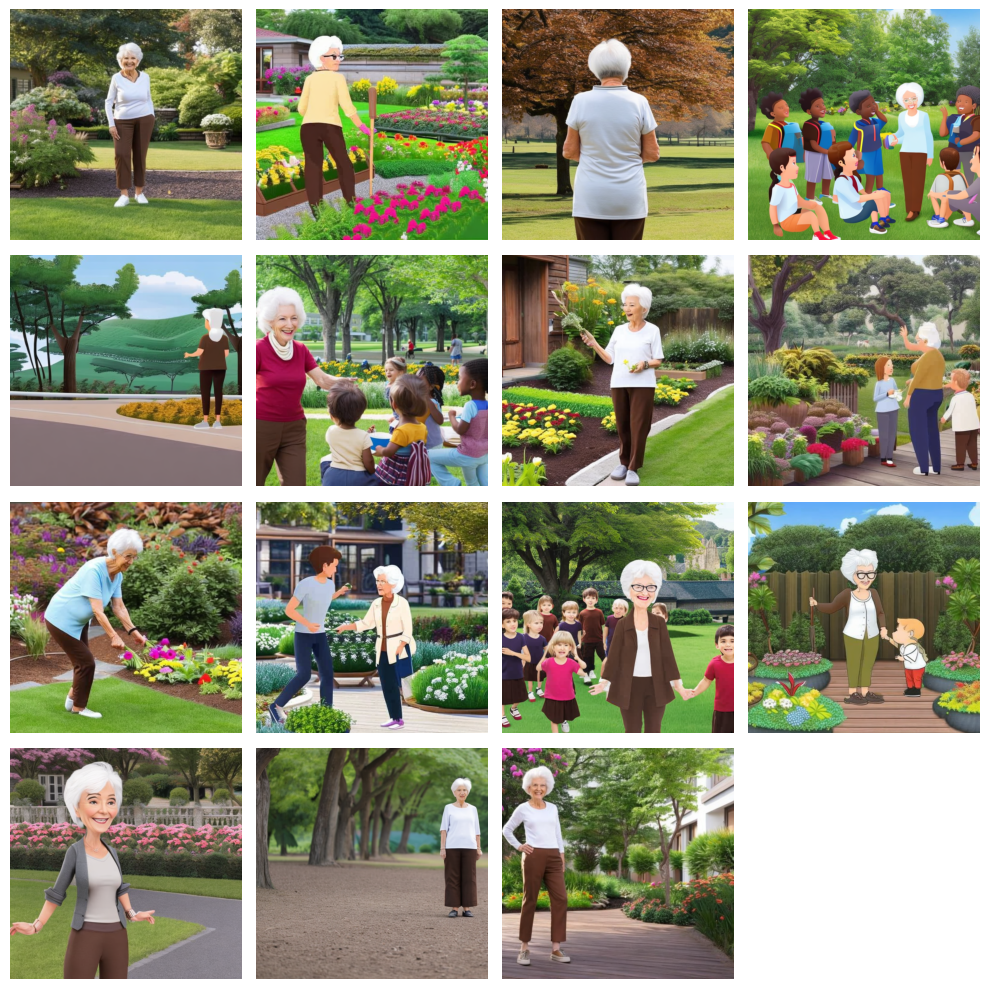

In [21]:
from IPython.display import clear_output
clear_output(wait=True)

num_images=3
enhancements= "Cartoon, tranquil, art"
subject = """Old woman white hair,wearing brown pants t-shirt sneakers """ 
actions = [
"""standing in front of a bare plot of a land at her local park """,
"""in garden planting a few flower beds and a small vegetable patch """,
"""in garden surrounded by people holding plants """,
"""in garden surrounded by school children, smiling, talking """,
"""in garden smiling, hands on hips """
]
negative="ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
output_dir="./output/cartoon/"
for i,action in enumerate(actions):
    model.generate_images(
        subject + action + enhancements,
        num_images=num_images,
        frame_num=i,
        save_path=output_dir,
        negative_prompt=negative

    )
display_generated_images(output_dir=output_dir)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Generated images...:


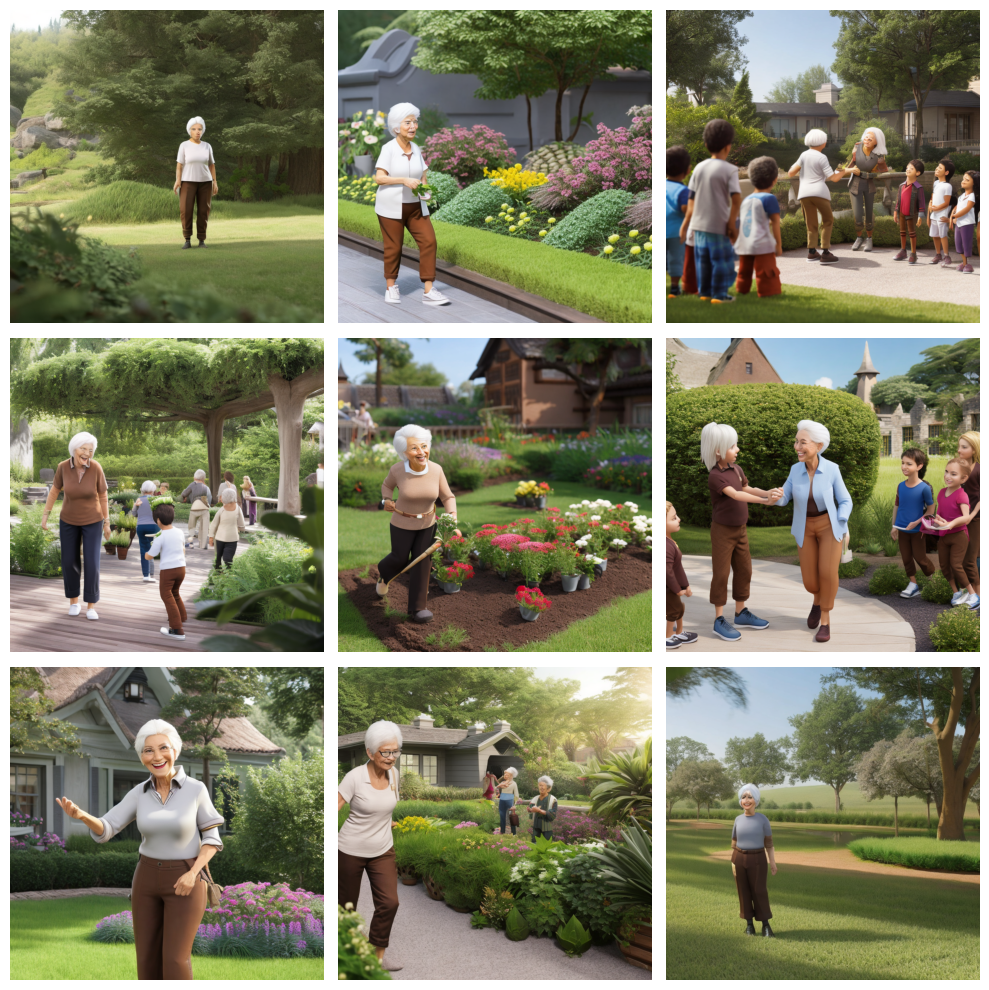

In [23]:
from IPython.display import clear_output
clear_output(wait=True)

num_images=1
enhancements= "anthro, disney pixar character concept artwork, 3d concept, high detail iconic character for upcoming film, trending on artstation, character design, 3d artistic render"
subject = """Old woman white hair,wearing brown pants t-shirt sneakers """ 
actions = [
"""standing in front of a bare plot of a land at her local park """,
"""in a garden planting a few flower beds and a small vegetable patch """,
"""in a garden surrounded by people holding plants """,
"""in a garden surrounded by school children, smiling, talking """,
"""in a garden holding an award """
]
negative="ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"
output_dir="./output/disney/"
for i,action in enumerate(actions):
    model.generate_images(
        subject + action + enhancements,
        num_images=num_images,
        frame_num=i,
        save_path=output_dir,
        num_inference_steps=50,
        negative_prompt=negative
    )
display_generated_images(output_dir=output_dir)


<!--#### Reference and Guidelines for Models Used in This Notebook

##### CompVis/stable-diffusion-v1-4
- **Model card:** [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- **License:** CreativeML OpenRAIL M license
- **Reference:**
    ```bibtex
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }
    ```

##### stabilityai/stable-diffusion-2
- **Model card:** [stabilityai/stable-diffusion-2](https://huggingface.co/stabilityai/stable-diffusion-2)
- **License:** CreativeML Open RAIL++-M License
- **Reference:**
    ```bibtex
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }
    ```

##### Disclaimer for Using Stable Diffusion Models

The stable diffusion models provided here are powerful tools for high-resolution image synthesis, including text-to-image and image-to-image transformations. While they are designed to produce high-quality results, users should be aware of potential limitations:

- **Quality Variation:** The quality of generated images may vary based on the complexity of the input text or image, and the alignment with the model's training data.
- **Licensing and Usage Constraints:** Please carefully review the licensing information associated with each model to ensure compliance with all terms and conditions.
- **Ethical Considerations:** Consider the ethical implications of the generated content, especially in contexts that may involve sensitive or controversial subjects.

For detailed information on each model's capabilities, limitations, and best practices, please refer to the respective model cards and associated publications linked below.

#### Reference and Guidelines for Models Used in This Notebook

##### stabilityai/stable-diffusion-2
- **Model card:** [stabilityai/stable-diffusion-2](https://huggingface.co/stabilityai/stable-diffusion-2)
- **License:** CreativeML Open RAIL++-M License
- **Reference:**
    ```bibtex
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }
    ```

#### Disclaimer for Using Stable Diffusion Models

The stable diffusion models provided here are powerful tools for high-resolution image synthesis, including text-to-image and image-to-image transformations. While they are designed to produce high-quality results, users should be aware of potential limitations:

- **Quality Variation:** The quality of generated images may vary based on the complexity of the input text or image, and the alignment with the model's training data.
- **Licensing and Usage Constraints:** Please carefully review the licensing information associated with each model to ensure compliance with all terms and conditions.
- **Ethical Considerations:** Consider the ethical implications of the generated content, especially in contexts that may involve sensitive or controversial subjects.

For detailed information on each model's capabilities, limitations, and best practices, please refer to the respective model cards and associated publications linked below.